<a href="https://colab.research.google.com/github/robgon-art/GANfolk/blob/main/GANfolk_StyleGAN_2_and_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GANfolk: Using AI to create portraits of fictional people to sell as NFTs**
## How to use GPT-3, StyleGAN2, and VQGAN to synthesize diverse characters from open-source images

By Robert. A Gonsalves</br></br>
<a href="https://opensea.io/collection/ganfolk">![sample images](https://raw.githubusercontent.com/robgon-art/GANfolk/main/GANfolk%20rect.png)</a>

You can see my article on Medium and check out the results here, [opensea.io/collection/ganfolk](https://opensea.io/collection/ganfolk)

The source code and generated images are released under the [CC BY-NC-SA license](https://creativecommons.org/licenses/by-nc-sa/4.0/).</br></br>
**If you use this project to create images, please give attribution like this:** This image was created with [GANfolk](https://opensea.io/collection/ganfolk) by [Robert A. Gonsalves](https://robgon.medium.com/).</br></br>
![CC BY-NC-SA](https://licensebuttons.net/l/by-sa/4.0/88x31.png)

## Acknowledgements
* StyleGAN 2 by T. Karras, et al., [Analyzing and Improving the Image Quality of StyleGAN](https://arxiv.org/pdf/1912.04958.pdf)</br>
* StyleGAN 2 implementation by rosinality, https://github.com/rosinality/stylegan2-pytorch</br>
* CLIP by A. Radford, et al., [Learning Transferable Visual Models From Natural Language Supervision](https://medium.com/r/?url=https%3A%2F%2Fcdn.openai.com%2Fpapers%2FLearning_Transferable_Visual_Models_From_Natural_Language_Supervision.pdf)</br>

In [ ]:
#@title Initialize the System
import glob
import os

!nvidia-smi
!git clone https://github.com/robgon-art/stylegan2-pytorch
!gdown --id 1qzIjtOdqg8YIRoFW0clWH9jhZ1Y14aNZ

!pio install openai
!pip install ninja
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
import torch
import warnings
warnings.filterwarnings('ignore')
import clip
from PIL import Image
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
def get_top_N_semantic_similarity(similarity_list, N):
  results = zip(range(len(similarity_list)), similarity_list)
  results = sorted(results, key=lambda x: x[1],reverse = True)
  scores = []
  indices = []
  for index,score in results[:N]:
    scores.append(score)
    indices.append(index)
  return scores, indices
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])

import torch
import sys
from torchvision import utils

import sys
sys.path.insert(0, "/content/stylegan2-pytorch")

import torch
from model import Generator
import matplotlib as mpl
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
import PIL
from IPython import display

input_resolution = 224
g_ema = Generator(size=512, style_dim=512, n_mlp=8, channel_multiplier=2).to("cuda")
checkpoint = torch.load("/content/GANfolk_stylegan2.pt")
g_ema.load_state_dict(checkpoint["g_ema"])

In [2]:
#@title Generate Samples { form-width: "50%" }
num_initial_samples = 200 #@param {type:"slider", min:20, max:500, step:20}

acc_image_features = torch.empty(0, 512)
acc_sample_images = torch.empty(0, 3, 512, 512)
acc_latents = torch.empty(0, 512)

num_batches = num_initial_samples // 20

from tqdm.notebook import tqdm
for b in tqdm(range(num_batches)):

  latents = torch.empty((20, 512), device="cuda")
  latents = torch.nn.init.trunc_normal_(latents, a=-0.7, b=0.7)

  # latents = torch.randn(20, 512, device="cuda")
  sample_images, _ = g_ema([latents], truncation=1, truncation_latent=None, return_latents=False, randomize_noise=False)
  sample_images_cpu = sample_images.detach().cpu()
  acc_sample_images = torch.vstack((acc_sample_images, sample_images_cpu))
  latents_cpu = latents.detach().cpu()
  acc_latents = torch.vstack((acc_latents, latents_cpu))
  del sample_images
  del latents
  image_input = F.interpolate(sample_images_cpu, input_resolution)

  image_input = np.clip((image_input + 1.0)/2.0, 0, 1)
  image_input -= image_mean[:, None, None]
  image_input /= image_std[:, None, None]

  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)
  acc_image_features = torch.vstack((acc_image_features, image_features))

  0%|          | 0/10 [00:00<?, ?it/s]

impressionist painting of a man


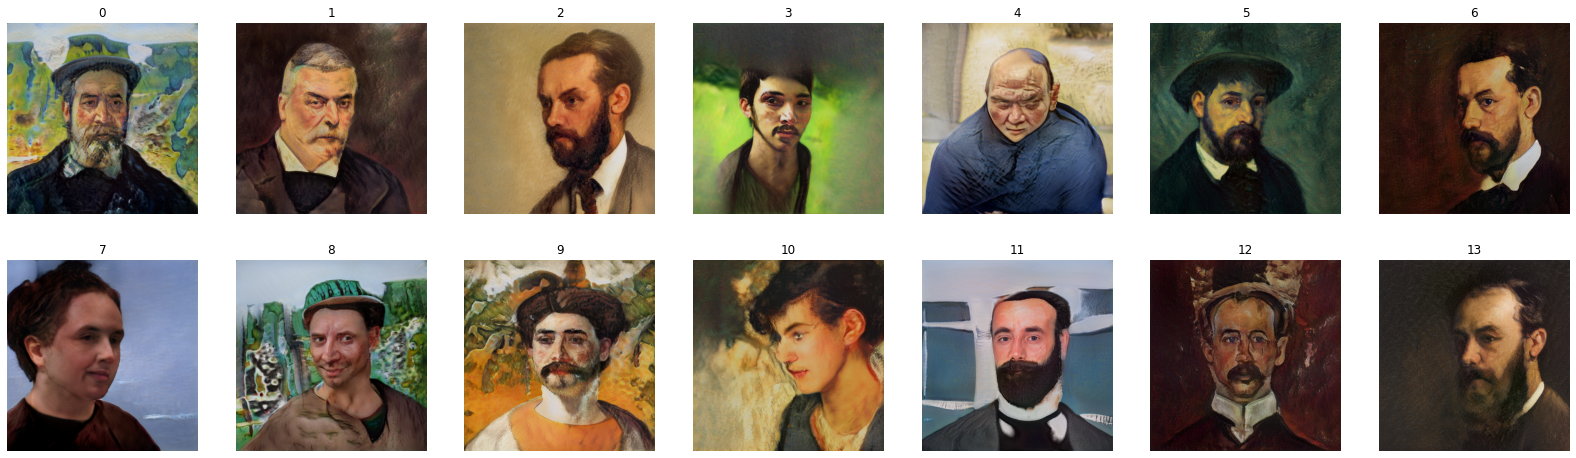

In [3]:
#@title Choose Prompt { form-width: "50%" }
prompt = "impressionist painting of a man" #@param {type:"string"}
print(prompt)

text = clip.tokenize(prompt).to("cpu")
with torch.no_grad():
  query_features = model.encode_text(text)

image_similarity = query_features.numpy() @ acc_image_features.numpy().T
image_similarity = image_similarity[0]

image_scores, image_indices = get_top_N_semantic_similarity(image_similarity, N=14)

best_images = torch.empty(0, 512, 512, 3)

for i in range(14):
  img = acc_sample_images[image_indices[i]][None, :]
  img = img.permute(0, 2, 3, 1)
  min = img.min() * 0.9
  max = img.max() * 1.1
  img = (img - min)/(max-min)
  img = img.clip(0, 1)
  best_images = torch.vstack((best_images, img))

  from numpy.core.numeric import count_nonzero
import matplotlib.pyplot as plt
import numpy as np

def plot_image_grid(images, ncols=None):
  if not ncols:
    factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
    ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
  nrows = int(len(images) / ncols) + int(len(images) % ncols)
  imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
  f, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
  axes = axes.flatten()[:len(imgs)]
  count = 0
  for img, ax in zip(imgs, axes.flatten()): 
    if np.any(img):
      if len(img.shape) > 2 and img.shape[2] == 1:
        img = img.squeeze()
      ax.title.set_text(count)
      ax.axis("off")
      ax.imshow(img)
      count += 1

# make 16 images with 60 height, 80 width, 3 color channels
images = np.random.rand(21, 512, 512, 3)

# plot them
plot_image_grid(best_images.cpu().detach().numpy(), ncols=7)

impressionist painting of a man



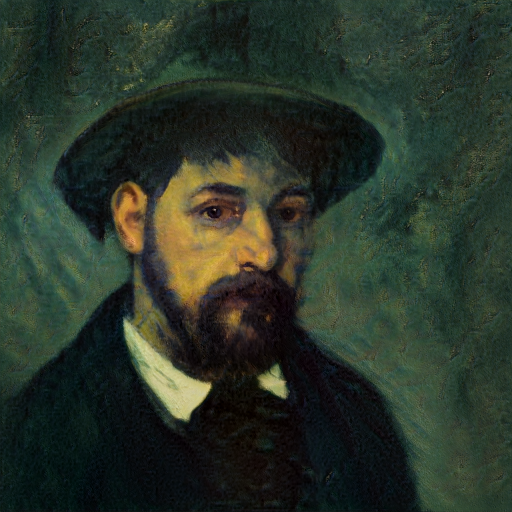

In [18]:
#@title Select_Image
print(prompt)
print()
select_image = 5 #@param {type:"slider", min:0, max:13, step:1}
img = best_images[select_image].cpu().detach().numpy()
img_int = np.clip(np.round(img*255), 0, 255).astype(np.uint8)
img_pil=PIL.Image.fromarray(img_int)
img_pil.save('out.png')
display.display(display.Image('out.png'))
print()
display.HTML('<strong>Please attribute as:</strong> This image was created with <a href="https://opensea.io/collection/ganfolk">GANfolk</a> by <a href="https://robgon.medium.com/">Robert A. Gonsalves</a>.') 